In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import pickle
import networkx as nx
from multiprocessing import Pool
from load_files_pop import (
    Ref,
    Z_20,
    Ref_pop20,
    Z_200,
    Ref_pop200,
    Z_2000,
    Ref_pop2000
)
from Reference_pop import simulate_reference_time_series
from plot_search_results import (
    plot_pareto_front3D,
    plot_pulse_ensemble_time_series,
    plot_ref_ensemble_time_series
)
from define_circuit import Topo
from amplifier_problem import Amplifier
from signal_conditioner_problem import SignalConditioner

orange_ = [i/255 for i in [230, 159, 0]]
sky_blue = [i/255 for i in [86, 180, 233]]
pink_ = [i/255 for i in [204, 121, 167]]
bluish_green = [i/255 for i in [0, 158, 115]]
vermillion = [i/255 for i in [213, 94, 0]]
yellow_ = [i/255 for i in [240, 228, 66]]
blue_ = [i/255 for i in [0, 114, 178]]

colors = [orange_, sky_blue, pink_, bluish_green, vermillion, yellow_, blue_]

### Amplifier Z matrix sampling all circuits vs. top pct

0.31997120997736345


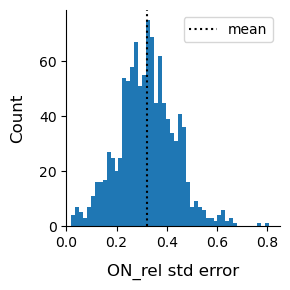

In [32]:
plt.figure(figsize=(3, 3))
path_Z_sample = "/Users/kdreyer/Documents/Github/GraphGA/GA_results/Amp_seed_pop_vary_dose/Original_hyperparams_worked_well/2024-04-23_Amplifier_pop_vary_dose_original_hp_seed_0/Amplifier_pop_vary_dose_Z_matrix_sampling_all/Z_matrix_sampling_for_CI.pkl"
with open(path_Z_sample, "rb") as fid:
    Z_sample = pickle.load(fid)
print(np.mean(Z_sample["ON_rel_std_error"]))
# print(max(Z_sample["ON_rel_std_error"])*0.5)
plt.hist(Z_sample["ON_rel_std_error"], bins=50)
# Z_sample["ON_rel_std_error"].plot.density(ind=1000)
plt.axvline(x=np.mean(Z_sample["ON_rel_std_error"]), label="mean", linestyle="dotted", color="k", linewidth=1.5)
plt.xlim([0, 0.85])
plt.xlabel("ON_rel std error")
plt.ylabel("Count")
plt.legend()
plt.show()

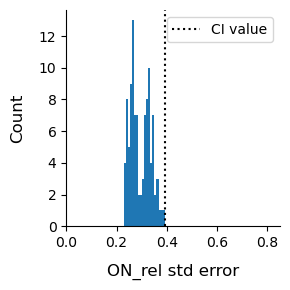

In [34]:
plt.figure(figsize=(3, 3))
path_Z_sample2 = "/Users/kdreyer/Documents/Github/GraphGA/GA_results/Amp_seed_pop_vary_dose/Original_hyperparams_worked_well/2024-04-23_Amplifier_pop_vary_dose_original_hp_seed_0/2024-04-24_Amplifier_pop_vary_dose_Z_matrix_sampling/Z_matrix_sampling_for_CI.pkl"
with open(path_Z_sample2, "rb") as fid:
    Z_sample2 = pickle.load(fid)
# print(max(Z_sample2["ON_rel_std_error"]))
plt.hist(Z_sample2["ON_rel_std_error"], bins=20)
plt.axvline(x=max(Z_sample2["ON_rel_std_error"]), label="CI value", linestyle="dotted", color="k", linewidth=1.5)
plt.xlim([0, 0.85])
plt.xlabel("ON_rel std error")
plt.ylabel("Count")
plt.legend()
plt.show()

### Amplifier CI circuit comparisons: 20 cell vs 200 cell vs 2000 cell

In [ ]:
path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/GA_results/Amp_seed_pop_vary_dose/Original_hyperparams_worked_well/2024-04-23_Amplifier_pop_vary_dose_original_hp_seed_0/2024-08-23_results_analysis_full_CI/selected_results_ON_rel_full_CI.pkl"
amp_CI = pd.read_pickle(path)
all_ON_rel_20 = amp_CI["ON_rel"].tolist()
all_ON_rel_200 = []
all_ON_rel_2000 = []
for index, row in amp_CI.iterrows():
    print("20 cell: ", all_ON_rel_20[index])
    topo = amp_CI.at[index, "Topology"]
    amp_problem_200 = Amplifier(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                           DsRed_inhibitor=False, num_dict={}, n_gen=None, probability_crossover=None, 
                           probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200, num_processes=8, max_time=42, single_cell_tracking=True)
    [ON_rel_200, all_cells_dict_200] = amp_problem_200.func(topo)
    print("200 cell: ", ON_rel_200)
    all_ON_rel_200.append(ON_rel_200)

    amp_problem_2000 = Amplifier(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                           DsRed_inhibitor=False, num_dict={}, n_gen=None, probability_crossover=None, 
                           probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_2000, num_processes=8, max_time=42, single_cell_tracking=True)
    [ON_rel_2000, all_cells_dict_2000] = amp_problem_2000.func(topo)
    print("2000 cell: ", ON_rel_2000)
    all_ON_rel_2000.append(ON_rel_2000)
    print("***** topology ", index, " done *****")

In [4]:
amp_pop_comparison = {"20_cell": all_ON_rel_20, "200_cell": all_ON_rel_200, "2000_cell": all_ON_rel_2000}
amp_pop_df = pd.DataFrame(amp_pop_comparison)
amp_pop_df_pos = amp_pop_df.abs()
path_save = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/GA_results/Amp_seed_pop_vary_dose/Original_hyperparams_worked_well/2024-04-23_Amplifier_pop_vary_dose_original_hp_seed_0/2024-08-23_results_analysis_full_CI/"
amp_pop_df_pos.to_csv(path_save+"pop_model_comparisons.csv")
x_vals = [0]*len(amp_pop_df_pos)
jittered_x = x_vals + np.random.rand(
    len(x_vals))
amp_pop_df_pos["jittered_x"] = jittered_x
# display(amp_pop_df_pos)

In [ ]:
path_save = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/GA_results/Amp_seed_pop_vary_dose/Original_hyperparams_worked_well/2024-04-23_Amplifier_pop_vary_dose_original_hp_seed_0/2024-08-23_results_analysis_full_CI/"

plt.figure(figsize=(3,3))
plt.plot(amp_pop_df_pos["jittered_x"], amp_pop_df_pos["20_cell"], label="20 cell model", linestyle="none", marker="o", markersize="4", zorder=1)
plt.plot(amp_pop_df_pos["jittered_x"], amp_pop_df_pos["200_cell"], label="200 cell model", linestyle="none", marker="o", markersize="4", zorder=2)
# plt.plot(amp_pop_df_pos["jittered_x"], amp_pop_df_pos["2000_cell"], label="2000 cell model", linestyle="none", marker="o", markersize="4")
lower_bound = [63.11786016]*len(amp_pop_df_pos)
upper_bound = [63.50911412131601]*len(amp_pop_df_pos)
jittered_x.sort()
plt.fill_between(jittered_x, lower_bound, upper_bound, alpha=0.3, color="grey", zorder=3)
plt.xticks([])
plt.legend()
# plt.show()
plt.savefig(path_save+"20vs200_cell_CI.svg")

### Signal conditioner pareto circuit comparisons: 20 cell vs 200 cell vs 2000 cell

In [ ]:
from signal_conditioner_problem import SignalConditioner
path_sc = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/GA_results/SC_seed_pop_DsRED_inhibitor/Original_hyperparams/SC_original_hp_seed_0/2024-09-05_results_analysis/selected_results_full_pareto_front.pkl"
sc_pareto = pd.read_pickle(path_sc)
# display(sc_pareto)

all_ON_rel_20 = sc_pareto["ON_rel"].tolist()
all_FI_rel_20 = sc_pareto["FI_rel"].tolist()
# num_topos = len(all_ON_rel_20)

all_ON_rel_200 = []
all_FI_rel_200 = []

# all_ON_rel_2000 = []
# all_FI_rel_2000 = []

for index, row in sc_pareto.iterrows():
    print("20 cell ON_rel, FI_rel: ", all_ON_rel_20[index], all_FI_rel_20[index])
    topo = sc_pareto.at[index, "Topology"]
    sc_problem_200 = SignalConditioner(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                           DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None, 
                           probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200, num_processes=8, max_time=42, single_cell_tracking=True)
    [[ON_rel_200, FI_rel_200], all_cells_dict_200] = sc_problem_200.func(topo)
    print("200 cell ON_rel, FI_rel: ", ON_rel_200, FI_rel_200)
    all_ON_rel_200.append(ON_rel_200)
    all_FI_rel_200.append(FI_rel_200)

    # sc_problem_2000 = SignalConditioner(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
    #                        DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None, 
    #                        probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_2000, num_processes=8, max_time=42, single_cell_tracking=True)
    # [[ON_rel_2000, FI_rel_2000], all_cells_dict_2000] = sc_problem_2000.func(topo)
    # print("2000 cell ON_rel, FI_rel: ", ON_rel_2000, FI_rel_2000)
    # all_ON_rel_2000.append(ON_rel_2000)
    # all_FI_rel_2000.append(FI_rel_2000)    
    # print("***** topology ", index, " done *****")
    # topo_num = index + 1
    # if topo_num == num_topos:
    #     break

sc_pop_comparison = {"20_cell_ON_rel": all_ON_rel_20, "20_cell_FI_rel": all_FI_rel_20,
                     "200_cell_ON_rel": all_ON_rel_200, "200_cell_FI_rel": all_FI_rel_200,
                    #  "2000_cell_ON_rel": all_ON_rel_2000, "2000_cell_FI_rel": all_FI_rel_2000,
}
sc_pop_df = pd.DataFrame(sc_pop_comparison)
sc_pop_df_pos = sc_pop_df.abs()
path_save = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/GA_results/SC_seed_pop_DsRED_inhibitor/Original_hyperparams/SC_original_hp_seed_0/2024-09-05_results_analysis/"
# sc_pop_df_pos.to_csv(path_save+"pop_model_comparisons_20v200.csv")

In [ ]:
results_path = "/Users/kdreyer/Documents/Github/GraphGA/" + "GA_results/SC_seed_pop_DsRED_inhibitor/Original_hyperparams/2024-05-02_Signal_Cond_pop_DsRED_inhibitor_original_hp_seed_0/"
obj_labels = ["ON_rel", "FI_rel"]
objectives_fname = "final_objectives_df.pkl"
pareto_front_objectives = pd.read_pickle(
    results_path+objectives_fname
)
selected_objectives = (
    pareto_front_objectives.drop_duplicates()
)
CI_metric_maxes = [0.7549563624285208, 0.004862470888440853]
obj1_CI = CI_metric_maxes[0]
obj2_CI = CI_metric_maxes[1]

upper_obj1 = np.abs(np.array(selected_objectives[obj_labels[0]]))
sorted_upper_idx = np.argsort(upper_obj1)
sorted_upper_obj1 = upper_obj1[sorted_upper_idx]

upper_obj1_plus = np.array([i+obj1_CI for i in upper_obj1])
sorted_upper_plus_idx = np.argsort(upper_obj1_plus)
sorted_upper_obj1_plus = upper_obj1_plus[sorted_upper_plus_idx]

lower_obj1 = np.array([i-obj1_CI for i in upper_obj1])
sorted_lower_idx = np.argsort(lower_obj1)
sorted_lower_obj1 = lower_obj1[sorted_lower_idx]

# upper_obj2 = np.array([i+obj2_CI_list[0] for i in (objectives[obj_labels[1]]*-1)])
upper_obj2 = np.abs(np.array(selected_objectives[obj_labels[1]]))
sorted_upper_obj2 = upper_obj2[sorted_upper_idx]

upper_obj2_plus = np.array([i+obj2_CI for i in upper_obj2])
sorted_upper_obj2_plus = upper_obj2_plus[sorted_upper_plus_idx]

lower_obj2 = np.array([i-obj2_CI for i in upper_obj2])
sorted_lower_obj2 = lower_obj2[sorted_lower_idx]

xfill = np.sort(np.concatenate([upper_obj1, lower_obj1]))
xfill_plus = np.sort(np.concatenate([upper_obj1_plus, lower_obj1]))

y1fill = np.interp(xfill, sorted_upper_obj1, sorted_upper_obj2)
y2fill = np.interp(xfill, sorted_lower_obj1, sorted_lower_obj2)
y2_plus_fill = np.interp(xfill_plus, sorted_lower_obj1, sorted_lower_obj2)
y1_plus_fill = np.interp(xfill_plus, sorted_upper_obj1_plus, sorted_upper_obj2_plus)
plt.figure(figsize=(5,5))
# plt.fill_between(xfill, y1fill, y2fill, alpha=0.3, color="grey", zorder=3)
plt.fill_between(xfill_plus, y1_plus_fill, y2_plus_fill, alpha=0.1, color="blue", zorder=1)
plt.plot(sc_pop_df_pos["20_cell_ON_rel"], sc_pop_df_pos["20_cell_FI_rel"], label="20 cell model", linestyle="none", marker="o", markersize="2", zorder=0)
plt.plot(sc_pop_df_pos["200_cell_ON_rel"], sc_pop_df_pos["200_cell_FI_rel"], label="200 cell model", linestyle="none", marker="o", markersize="2", zorder=1)
# plt.plot(sc_pop_df_pos["2000_cell_ON_rel"], sc_pop_df_pos["2000_cell_FI_rel"], label="2000 cell model", linestyle="none", marker="o", markersize="2")
# plt.legend()
# plt.xlim(left=40)
# plt.ylim(top=0.6)
# ax.plot(all_objectives[:, 0], all_objectives[:, 1], linestyle="none", 
#         marker="o", markersize=1, color="black", zorder=1)
plt.xlabel(obj_labels[0])
plt.ylabel(obj_labels[1])
plt.show()
# plt.savefig(results_path+"20vs200_cell_CI.svg", bbox_inches="tight")

In [ ]:
# all_ON_rel.sort()
# print(all_ON_rel)
#     if "Z2" in amp_CI.at[index, "Doses"].keys() and "Z6" in amp_CI.at[index, "Doses"].keys():
#         if len(amp_CI.at[index, "Edge list"]) == 10:
#             opt_topo_idx.append(index)
#             opt_topo_doses.append(amp_CI.at[index, "Doses"])
#         elif len(amp_CI.at[index, "Edge list"]) == 9:
#             if ("Z2", "Z2") in amp_CI.at[index, "Edge list"] and ("Z2", "Rep") in amp_CI.at[index, "Edge list"]:
#                 # print(amp_CI.at[index, "Edge list"])
#                 green_9_edge.append(index)
#             elif ("Z2", "Z2") in amp_CI.at[index, "Edge list"] and ("Z2", "Rep") not in amp_CI.at[index, "Edge list"]:
#                 # print(amp_CI.at[index, "Edge list"])
#                 yellow_9_edge.append(index)
#             # elif ("Z2", "Z2") not in amp_CI.at[index, "Edge list"]:
#             else:
#                 orange_9_edge.append(index)
#         elif len(amp_CI.at[index, "Edge list"]) == 8:
#             if ("Z2", "Z2") not in amp_CI.at[index, "Edge list"]:
#                 pink_8_edge.append(index)
#             else:
#                 purple_8_edge.append(index)        
#     else:
#         other_ZFs_idx.append(index)
#         print(index, amp_CI.at[index, "Edge list"])
# # print(len(opt_topo_doses))
# print(other_ZFs_idx)

In [9]:
path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/GA_results/Amp_seed_pop_vary_dose/Original_hyperparams_worked_well/2024-04-23_Amplifier_pop_vary_dose_original_hp_seed_0/unique_objectives.pkl"

unique_objs = pd.read_pickle(path).flatten()
sorted_objs = np.abs(np.sort(unique_objs))
# print(sorted_objs)
gte_2pct = [i for i in sorted_objs if i >= 62.23882]
print(gte_2pct)

[63.50911412131601, 63.49545615444392, 63.46534288483589, 63.44859978519295, 63.43047788827621, 63.41988855507306, 63.410717518216806, 63.39267642225555, 63.38897516037089, 63.38354197593723, 63.377559248907716, 63.37248174056797, 63.364782033939875, 63.36120905319644, 63.360687472990165, 63.34242620837478, 63.33777376957212, 63.33747223483946, 63.31969249003355, 63.30911270447212, 63.30605189528603, 63.29060004719942, 63.27934212088281, 63.2775255312696, 63.27057138534992, 63.26893072215486, 63.248741840751, 63.23725516559097, 63.22858935168875, 63.22473567666408, 63.22330207788045, 63.22105184404451, 63.216870766566046, 63.204779220030495, 63.19896266185474, 63.19879178624709, 63.1980396334818, 63.19226203712781, 63.192034193329796, 63.18457190815275, 63.17526224408508, 63.16792562445763, 63.16563631068892, 63.163394899719336, 63.16318590017984, 63.152982955663866, 63.14929598721099, 63.138831932641004, 63.12214541657147, 63.11029544860333, 63.10986837228235, 63.09736692859343, 63.09

In [ ]:
path_obj = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/GA_results/SC_seed_single_cell_DsRED_inhibitor/Original_hyperparams/SC_original_hp_seed_3/final_objectives_df.pkl"
path_circuit = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/GA_results/SC_seed_single_cell_DsRED_inhibitor/Original_hyperparams/SC_original_hp_seed_3/final_population.pkl"

objs = pd.read_pickle(path_obj)
circuits = pd.read_pickle(path_circuit)
# circuits[1][0].plot_graph()
# display(objs)
display(objs[objs["type"] == "Inhibitors"])

## Amplifier and signal conditioner pre GA 20v200 cell model comparison (using single cell results)

### Amplifier

In [9]:
amp_single_path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Amplifier_single_cell/Original_hyperparams_vary_dose/Amplifier_single_cell_vary_dose_original_hp_seed_0/"
obj_fname = "all_unique_obj.pkl"
circuit_fname = "all_unique_circuits.pkl"

with open(amp_single_path+obj_fname, "rb") as fid:
    amp_single_obj = pickle.load(fid)
amp_single_obj = abs(amp_single_obj.flatten())
with open(amp_single_path+circuit_fname, "rb") as fid:
    amp_single_circuits = pickle.load(fid)
amp_single_circuits = amp_single_circuits.flatten()

selected_obj_idx_high = np.where(
    amp_single_obj > 63
)[0]
selected_unique_obj_high = amp_single_obj[selected_obj_idx_high]
# print(len(selected_unique_obj_high))
selected_unique_circuits_high = amp_single_circuits[selected_obj_idx_high]


selected_obj_idx_mid = np.where(
    np.logical_and(
        amp_single_obj > 37, 
        amp_single_obj < 42))[0]
selected_unique_obj_mid = amp_single_obj[selected_obj_idx_mid]
selected_unique_circuits_mid = amp_single_circuits[selected_obj_idx_mid]
# print(len(selected_unique_obj_mid))

selected_obj_idx_low = np.where(
        amp_single_obj < 20
        )[0]
selected_unique_obj_low = amp_single_obj[selected_obj_idx_low]
selected_unique_circuits_low = amp_single_circuits[selected_obj_idx_low]

# print(len(selected_unique_obj_low))

### high

In [19]:
amp_problem_20 = Amplifier(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                        DsRed_inhibitor=False, num_dict={}, n_gen=None, probability_crossover=None, 
                        probability_mutation=None, mutate_dose=True, pop=True, CI=None, num_processes=8, max_time=42, single_cell_tracking=False)


amp_problem_200 = Amplifier(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                        DsRed_inhibitor=False, num_dict={}, n_gen=None, probability_crossover=None, 
                        probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200, num_processes=8, max_time=42, single_cell_tracking=False)

# if __name__ == "__main__":
#     with Pool(8) as pool:
#         all_ON_rel_20 = pool.imap(amp_problem_20.func, selected_unique_circuits_high)
#         pool.close()
#         pool.join()
#     all_ON_rel_20 = list(all_ON_rel_20)
#     all_ON_rel_20 = np.asarray(all_ON_rel_20)

#     with Pool(8) as pool:
#         all_ON_rel_200 = pool.imap(amp_problem_200.func, selected_unique_circuits_high)
#         pool.close()
#         pool.join()
#     all_ON_rel_200 = list(all_ON_rel_200)
#     all_ON_rel_200 = np.asarray(all_ON_rel_200)


# amp_pop_comparison = {"20_cell": all_ON_rel_20, "200_cell": all_ON_rel_200}
# amp_pop_df = pd.DataFrame(amp_pop_comparison)
# amp_pop_df_pos = amp_pop_df.abs()
# path_save = amp_single_path + "pop20v200_comparison_high/"
# amp_pop_df_pos.to_csv(path_save+"pop_model_comparisons.csv")

### mid-range

In [20]:
amp_problem_20 = Amplifier(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                        DsRed_inhibitor=False, num_dict={}, n_gen=None, probability_crossover=None, 
                        probability_mutation=None, mutate_dose=True, pop=True, CI=None, num_processes=8, max_time=42, single_cell_tracking=False)


amp_problem_200 = Amplifier(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                        DsRed_inhibitor=False, num_dict={}, n_gen=None, probability_crossover=None, 
                        probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200, num_processes=8, max_time=42, single_cell_tracking=False)


# if __name__ == "__main__":
#     with Pool(8) as pool:
#         all_ON_rel_20 = pool.imap(amp_problem_20.func, selected_unique_circuits_mid)
#         pool.close()
#         pool.join()
#     all_ON_rel_20 = list(all_ON_rel_20)
#     all_ON_rel_20 = np.asarray(all_ON_rel_20)

#     with Pool(8) as pool:
#         all_ON_rel_200 = pool.imap(amp_problem_200.func, selected_unique_circuits_mid)
#         pool.close()
#         pool.join()
#     all_ON_rel_200 = list(all_ON_rel_200)
#     all_ON_rel_200 = np.asarray(all_ON_rel_200)


# amp_pop_comparison = {"20_cell": all_ON_rel_20, "200_cell": all_ON_rel_200}
# amp_pop_df = pd.DataFrame(amp_pop_comparison)
# amp_pop_df_pos = amp_pop_df.abs()
# path_save = amp_single_path + "pop20v200_comparison_mid-range/"
# amp_pop_df_pos.to_csv(path_save+"pop_model_comparisons.csv")

### low

In [21]:
amp_problem_20 = Amplifier(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                        DsRed_inhibitor=False, num_dict={}, n_gen=None, probability_crossover=None, 
                        probability_mutation=None, mutate_dose=True, pop=True, CI=None, num_processes=8, max_time=42, single_cell_tracking=False)


amp_problem_200 = Amplifier(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                        DsRed_inhibitor=False, num_dict={}, n_gen=None, probability_crossover=None, 
                        probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200, num_processes=8, max_time=42, single_cell_tracking=False)


# if __name__ == "__main__":
#     with Pool(8) as pool:
#         all_ON_rel_20 = pool.imap(amp_problem_20.func, selected_unique_circuits_low)
#         pool.close()
#         pool.join()
#     all_ON_rel_20 = list(all_ON_rel_20)
#     all_ON_rel_20 = np.asarray(all_ON_rel_20)

#     with Pool(8) as pool:
#         all_ON_rel_200 = pool.imap(amp_problem_200.func, selected_unique_circuits_low)
#         pool.close()
#         pool.join()
#     all_ON_rel_200 = list(all_ON_rel_200)
#     all_ON_rel_200 = np.asarray(all_ON_rel_200)


# amp_pop_comparison = {"20_cell": all_ON_rel_20, "200_cell": all_ON_rel_200}
# amp_pop_df = pd.DataFrame(amp_pop_comparison)
# amp_pop_df_pos = amp_pop_df.abs()
# path_save = amp_single_path + "pop20v200_comparison_low/"
# amp_pop_df_pos.to_csv(path_save+"pop_model_comparisons.csv")

### Signal conditioner

In [ ]:
path_unique_objs = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Signal_conditioner_single_cell/synTF-R-DsR/Optimized_hyperparams_fixed_pop_max_hv_ngen50/run4_ngen120/2024-10-04_Signal_cond_single_DsRED_opt_hps_run4_seed_3/"
fname = "all_unique_obj.pkl"
pareto_fname = "final_objectives_df.pkl"

with open(path_unique_objs+fname, "rb") as fid:
    objs = pickle.load(fid)
# print(len(objs))
pareto_objs = pd.read_pickle(path_unique_objs+pareto_fname)

# plt.plot(abs(objs[:, 0]), abs(objs[:, 1]), linestyle="none", marker="o", markersize="2")
# plt.plot(abs(pareto_objs["ON_rel"]), abs(pareto_objs["FI_rel"]), linestyle="none", marker="o", markersize="2")
# plt.xlim([0, 10])
# plt.axvline(2.5, 0, 1.8, color="grey")
# plt.axhline(1.0, 0, 10)
# plt.axhline(0.75, 0, 10)
# plt.show()

In [61]:
path_sc = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Signal_conditioner_single_cell/synTF-R-DsR/Optimized_hyperparams_fixed_pop_max_hv_ngen50/run4_ngen120/2024-10-04_Signal_cond_single_DsRED_opt_hps_run4_seed_3/"
pareto_fname = "final_objectives_df.pkl"
pareto_circuits_fname = "final_population.pkl"
unique_obj_fname = "all_unique_obj.pkl"
unique_circuits_fname = "all_unique_circuits.pkl"

sc_pareto = pd.read_pickle(path_sc+pareto_fname)
# display(sc_pareto)
with open(path_sc+pareto_circuits_fname, "rb") as fid:
    pareto_circuits = pickle.load(fid)
pareto_circuits = pareto_circuits.flatten()
with open(path_sc+unique_obj_fname, "rb") as fid:
    unique_obj = pickle.load(fid)
unique_obj_df = pd.DataFrame(unique_obj, columns=["ON_rel", "FI_rel"])
unique_obj_df = abs(unique_obj_df)
with open(path_sc+unique_circuits_fname, "rb") as fid:
    unique_circuits = pickle.load(fid)
unique_circuits = unique_circuits.flatten()
unique_obj_df["Topology"] = unique_circuits
# display(unique_obj_df)

selected_obj_mid = unique_obj_df[
    (unique_obj_df["ON_rel"] < 2.5) &
    ((unique_obj_df["FI_rel"] > 1.0) & (unique_obj_df["FI_rel"] < 1.5))
]

selected_obj_low = unique_obj_df[
    (unique_obj_df["ON_rel"] < 1.6) &
    ((unique_obj_df["FI_rel"] > 0.75) & (unique_obj_df["FI_rel"] < 1.0))
]
# display(selected_obj_mid)
# print(len(selected_obj_low))
# print(len(selected_obj_mid))
# plt.plot(abs(objs[:, 0]), abs(objs[:, 1]), linestyle="none", marker="o", markersize="2")
# plt.plot(abs(pareto_objs["ON_rel"]), abs(pareto_objs["FI_rel"]), linestyle="none", marker="o", markersize="2")
# plt.plot(selected_obj_low["ON_rel"], selected_obj_low["FI_rel"], linestyle="none", marker="o", markersize="2")
# plt.xlim([0, 10])
# plt.axvline(1.6, 0, 1.8, color="grey")
# plt.axhline(1.5, 0, 10)
# plt.axhline(1, 0, 10)
# plt.show()

,ON_rel,FI_rel,Topology
8274,2.462657,1.032326,<define_circuit.Topo object at 0x145bc3c10>
8282,2.375293,1.038589,<define_circuit.Topo object at 0x145bc1570>
8291,2.296244,1.102173,<define_circuit.Topo object at 0x145c0dd50>
8294,2.283946,1.045725,<define_circuit.Topo object at 0x145c0dea0>
8306,2.215916,1.110819,<define_circuit.Topo object at 0x145c0feb0>
...,...,...,...
8634,0.505373,1.057794,<define_circuit.Topo object at 0x144bbb3d0>
8635,0.498938,1.040434,<define_circuit.Topo object at 0x144bb9b10>
8651,0.422245,1.095220,<define_circuit.Topo object at 0x144bba4a0>
8661,0.391848,1.057667,<define_circuit.Topo object at 0x144b6a440>


### pareto

In [60]:
sc_problem_20 = SignalConditioner(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                        DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None, 
                        probability_mutation=None, mutate_dose=True, pop=True, CI=None, num_processes=8, max_time=42, single_cell_tracking=False)

sc_problem_200 = SignalConditioner(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                        DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None, 
                        probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200, num_processes=8, max_time=42, single_cell_tracking=False)


if __name__ == "__main__":
    with Pool(8) as pool:
        all_objs_20 = pool.imap(sc_problem_20.func, pareto_circuits)
        pool.close()
        pool.join()
    all_objs_20 = list(all_objs_20)
    all_objs_20 = np.asarray(all_objs_20)
    all_ON_rel_20 = all_objs_20[:,0]
    all_FI_rel_20 = all_objs_20[:,1]

    with Pool(8) as pool:
        all_objs_200 = pool.imap(sc_problem_200.func, pareto_circuits)
        pool.close()
        pool.join()
    all_objs_200 = list(all_objs_200)
    all_objs_200 = np.asarray(all_objs_200)
    all_ON_rel_200 = all_objs_200[:,0]
    all_FI_rel_200 = all_objs_200[:,1]


sc_pop_comparison = {"20_cell_ON_rel": all_ON_rel_20, "20_cell_FI_rel": all_FI_rel_20,
                    "200_cell_ON_rel": all_ON_rel_200, "200_cell_FI_rel": all_FI_rel_200,
}
sc_pop_df = pd.DataFrame(sc_pop_comparison)
sc_pop_df_pos = sc_pop_df.abs()

path_save = path_sc + "pop20v200_comparison_pareto/"
sc_pop_df_pos.to_csv(path_save+"pop_model_comparisons.csv")

### mid-range

In [62]:
sc_problem_20 = SignalConditioner(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                        DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None, 
                        probability_mutation=None, mutate_dose=True, pop=True, CI=None, num_processes=8, max_time=42, single_cell_tracking=False)

sc_problem_200 = SignalConditioner(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                        DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None, 
                        probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200, num_processes=8, max_time=42, single_cell_tracking=False)

topologies = selected_obj_mid["Topology"].tolist()
if __name__ == "__main__":
    with Pool(8) as pool:
        all_objs_20 = pool.imap(sc_problem_20.func, topologies)
        pool.close()
        pool.join()
    all_objs_20 = list(all_objs_20)
    all_objs_20 = np.asarray(all_objs_20)
    all_ON_rel_20 = all_objs_20[:,0]
    all_FI_rel_20 = all_objs_20[:,1]

    with Pool(8) as pool:
        all_objs_200 = pool.imap(sc_problem_200.func, topologies)
        pool.close()
        pool.join()
    all_objs_200 = list(all_objs_200)
    all_objs_200 = np.asarray(all_objs_200)
    all_ON_rel_200 = all_objs_200[:,0]
    all_FI_rel_200 = all_objs_200[:,1]


sc_pop_comparison = {"20_cell_ON_rel": all_ON_rel_20, "20_cell_FI_rel": all_FI_rel_20,
                    "200_cell_ON_rel": all_ON_rel_200, "200_cell_FI_rel": all_FI_rel_200,
}
sc_pop_df = pd.DataFrame(sc_pop_comparison)
sc_pop_df_pos = sc_pop_df.abs()

path_save = path_sc + "pop20v200_comparison_mid-range/"
sc_pop_df_pos.to_csv(path_save+"pop_model_comparisons.csv")

### low

In [63]:
sc_problem_20 = SignalConditioner(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                        DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None, 
                        probability_mutation=None, mutate_dose=True, pop=True, CI=None, num_processes=8, max_time=42, single_cell_tracking=False)

sc_problem_200 = SignalConditioner(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                        DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None, 
                        probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200, num_processes=8, max_time=42, single_cell_tracking=False)

topologies = selected_obj_low["Topology"].tolist()
if __name__ == "__main__":
    with Pool(8) as pool:
        all_objs_20 = pool.imap(sc_problem_20.func, topologies)
        pool.close()
        pool.join()
    all_objs_20 = list(all_objs_20)
    all_objs_20 = np.asarray(all_objs_20)
    all_ON_rel_20 = all_objs_20[:,0]
    all_FI_rel_20 = all_objs_20[:,1]

    with Pool(8) as pool:
        all_objs_200 = pool.imap(sc_problem_200.func, topologies)
        pool.close()
        pool.join()
    all_objs_200 = list(all_objs_200)
    all_objs_200 = np.asarray(all_objs_200)
    all_ON_rel_200 = all_objs_200[:,0]
    all_FI_rel_200 = all_objs_200[:,1]


sc_pop_comparison = {"20_cell_ON_rel": all_ON_rel_20, "20_cell_FI_rel": all_FI_rel_20,
                    "200_cell_ON_rel": all_ON_rel_200, "200_cell_FI_rel": all_FI_rel_200,
}
sc_pop_df = pd.DataFrame(sc_pop_comparison)
sc_pop_df_pos = sc_pop_df.abs()

path_save = path_sc + "pop20v200_comparison_low/"
sc_pop_df_pos.to_csv(path_save+"pop_model_comparisons.csv")

## Amplifier and signal conditioner post-facto 20v200 cell model comparison

### Amplifier

In [ ]:
amp_pop_path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Amplifier_pop/Original_hyperparams_vary_dose/Amplifier_pop_vary_dose_original_hp_seed_0/"
obj_fname = "unique_objectives.pkl"
circuit_fname = "unique_circuits.pkl"
with open(amp_pop_path+obj_fname, "rb") as fid:
    amp_pop20_obj = pickle.load(fid)
amp_pop20_obj = abs(amp_pop20_obj.flatten())
with open(amp_pop_path+circuit_fname, "rb") as fid:
    amp_pop20_circuits = pickle.load(fid)
amp_pop20_circuits = amp_pop20_circuits.flatten()

selected_obj_idx_mid = np.where(
    np.logical_and(
        amp_pop20_obj > 37, 
        amp_pop20_obj < 42))[0]
selected_unique_obj_mid = amp_pop20_obj[selected_obj_idx_mid]
selected_unique_circuits_mid = amp_pop20_circuits[selected_obj_idx_mid]

selected_obj_idx_low = np.where(
        amp_pop20_obj < 20
        )[0]
selected_unique_obj_low = amp_pop20_obj[selected_obj_idx_low]
selected_unique_circuits_low = amp_pop20_circuits[selected_obj_idx_low]
print(selected_unique_obj_low)

#### mid-range ON_rel

In [ ]:
amp_problem_200 = Amplifier(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                        DsRed_inhibitor=False, num_dict={}, n_gen=None, probability_crossover=None, 
                        probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200, num_processes=8, max_time=42, single_cell_tracking=False)

all_ON_rel_200 = []
for i, circuit in enumerate(selected_unique_circuits_mid):
    print("20 cell: ", selected_unique_obj_mid[i])
    ON_rel_200 = amp_problem_200.func(circuit)
    print("200 cell: ", ON_rel_200)
    all_ON_rel_200.append(ON_rel_200)
    print("topology", i, " done")
    print("")


amp_pop_comparison = {"20_cell": selected_unique_obj_mid, "200_cell": all_ON_rel_200}
amp_pop_df = pd.DataFrame(amp_pop_comparison)
amp_pop_df_pos = amp_pop_df.abs()
path_save = amp_pop_path + "pop200_comparison_mid-range/"
amp_pop_df_pos.to_csv(path_save+"pop_model_comparisons.csv")


In [ ]:
x_vals = [0]*len(amp_pop_df_pos)
jittered_x = x_vals + np.random.rand(
    len(x_vals))
amp_pop_df_pos["jittered_x"] = jittered_x

plt.figure(figsize=(3,3))
plt.plot(amp_pop_df_pos["jittered_x"], amp_pop_df_pos["20_cell"], label="20 cell model", linestyle="none", marker="o", markersize="4", zorder=1)
plt.plot(amp_pop_df_pos["jittered_x"], amp_pop_df_pos["200_cell"], label="200 cell model", linestyle="none", marker="o", markersize="4", zorder=2)
plt.xticks([])
plt.legend()
# plt.show()
plt.savefig(path_save+"20vs200_cell_ON_rel_mid.svg")

#### low ON_rel

In [ ]:
amp_problem_200 = Amplifier(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True, 
                        DsRed_inhibitor=False, num_dict={}, n_gen=None, probability_crossover=None, 
                        probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200, num_processes=8, max_time=42, single_cell_tracking=False)

all_ON_rel_200 = []
for i, circuit in enumerate(selected_unique_circuits_low):
    print("20 cell: ", selected_unique_obj_low[i])
    ON_rel_200 = amp_problem_200.func(circuit)
    print("200 cell: ", ON_rel_200)
    all_ON_rel_200.append(ON_rel_200)
    print("topology", i, " done")
    print("")


amp_pop_comparison = {"20_cell": selected_unique_obj_low, "200_cell": all_ON_rel_200}
amp_pop_df = pd.DataFrame(amp_pop_comparison)
amp_pop_df_pos = amp_pop_df.abs()
path_save = amp_pop_path + "pop200_comparison_low/"
amp_pop_df_pos.to_csv(path_save+"pop_model_comparisons.csv")

In [ ]:
x_vals = [0]*len(amp_pop_df_pos)
jittered_x = x_vals + np.random.rand(
    len(x_vals))
amp_pop_df_pos["jittered_x"] = jittered_x

plt.figure(figsize=(3,3))
plt.plot(amp_pop_df_pos["jittered_x"], amp_pop_df_pos["20_cell"], label="20 cell model", linestyle="none", marker="o", markersize="4", zorder=1)
plt.plot(amp_pop_df_pos["jittered_x"], amp_pop_df_pos["200_cell"], label="200 cell model", linestyle="none", marker="o", markersize="4", zorder=2)
plt.xticks([])
plt.ylabel("ON_rel")
plt.legend()
# plt.show()
plt.savefig(path_save+"20vs200_cell_ON_rel_low.svg")

### Signal conditioner: original hyperparameters

In [33]:
sc_pop_path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Signal_conditioner_pop/synTF-R-DsR/Original_hyperparams/SC_original_hp_seed_0/"
obj_fname = "unique_objectives_df.pkl"
circuit_fname = "unique_circuits.pkl"

unique_obj_df = pd.read_pickle(sc_pop_path+obj_fname).abs()
with open(sc_pop_path+circuit_fname, "rb") as fid:
    sc_pop20_circuits = pickle.load(fid)
sc_pop20_circuits = sc_pop20_circuits.flatten()
# display(unique_obj_df)

selected_obj_mid = unique_obj_df[
    (unique_obj_df["ON_rel"] < 15) &
    ((unique_obj_df["FI_rel"] > 0.7) & (unique_obj_df["FI_rel"] < 0.8))
]
unique_obj_mid = selected_obj_mid.copy()
unique_ON_rel_mid = unique_obj_mid["ON_rel"].tolist()
unique_FI_rel_mid = unique_obj_mid["FI_rel"].tolist()

selected_obj_idx_m = selected_obj_mid.index.tolist()
selected_circuits_mid = sc_pop20_circuits[selected_obj_idx_m]

selected_obj_low = unique_obj_df[
    ((unique_obj_df["ON_rel"] > 15) & (unique_obj_df["ON_rel"] < 30)) &
    ((unique_obj_df["FI_rel"] > 0.4) & (unique_obj_df["FI_rel"] < 0.5))
]

unique_obj_low = selected_obj_low.copy()
unique_ON_rel_low = unique_obj_low["ON_rel"].tolist()
unique_FI_rel_low = unique_obj_low["FI_rel"].tolist()

selected_obj_idx_l = selected_obj_low.index.tolist()
selected_circuits_low = sc_pop20_circuits[selected_obj_idx_l]

# plt.plot(unique_obj_df["ON_rel"], unique_obj_df["FI_rel"],  linestyle="none", marker="o")
# plt.plot(unique_obj_mid["ON_rel"], unique_obj_mid["FI_rel"], linestyle="none", marker="o")
# plt.plot(unique_obj_low["ON_rel"], unique_obj_low["FI_rel"], linestyle="none", marker="o")


#### signal conditioner original hyperparameters mid-range objs

In [ ]:
signal_cond_200 = SignalConditioner(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True,
                                    DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None,
                                    probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200,
                                    num_processes=8, max_time=42, single_cell_tracking=False)

all_ON_rel_200 = []
all_FI_rel_200 = []
for i, circuit in enumerate(selected_circuits_mid):
    print("20 cell ON_rel, FI_rel: ", unique_ON_rel_mid[i], unique_FI_rel_mid[i])
    [ON_rel_200, FI_rel_200] = signal_cond_200.func(circuit)
    print("200 cell ON_rel, FI_rel: ", -ON_rel_200, -FI_rel_200)
    all_ON_rel_200.append(ON_rel_200)
    all_FI_rel_200.append(FI_rel_200)
    print("topology", i, " done")
    print("")


sc_pop_comparison = {"20_cell ON_rel": unique_ON_rel_mid,
                     "20_cell FI_rel": unique_FI_rel_mid,
                     "200_cell ON_rel": all_ON_rel_200,
                     "200_cell FI_rel": all_FI_rel_200}


sc_pop_df = pd.DataFrame(sc_pop_comparison)
sc_pop_df_pos = sc_pop_df.abs()
path_save = sc_pop_path + "pop200_comparison_mid/"
sc_pop_df_pos.to_csv(path_save+"pop_model_comparisons.csv")

In [ ]:
plt.figure(figsize=(3,3))
plt.plot(sc_pop_df_pos["20_cell ON_rel"], sc_pop_df_pos["20_cell FI_rel"], label="20 cell model", linestyle="none", marker="o", markersize="4", zorder=1)
plt.plot(sc_pop_df_pos["200_cell ON_rel"], sc_pop_df_pos["200_cell FI_rel"], label="200 cell model", linestyle="none", marker="o", markersize="4", zorder=2)
plt.xlabel("ON_rel")
plt.ylabel("FI_rel")
plt.legend()
# plt.show()
plt.savefig(path_save+"20vs200_cell_objs_mid.svg")

#### signal conditioner original hyperparameters low objs (FI_rel)

In [ ]:
signal_cond_200 = SignalConditioner(promo_node="P1", dose_specs=[5, 75, 5], max_part=2, inhibitor=True,
                                    DsRed_inhibitor=True, num_dict={}, n_gen=None, probability_crossover=None,
                                    probability_mutation=None, mutate_dose=True, pop=True, CI=None, Z_mat = Z_200,
                                    num_processes=8, max_time=42, single_cell_tracking=False)

all_ON_rel_200 = []
all_FI_rel_200 = []
for i, circuit in enumerate(selected_circuits_low):
    print("20 cell ON_rel, FI_rel: ", unique_ON_rel_low[i], unique_FI_rel_low[i])
    [ON_rel_200, FI_rel_200] = signal_cond_200.func(circuit)
    print("200 cell ON_rel, FI_rel: ", -ON_rel_200, -FI_rel_200)
    all_ON_rel_200.append(ON_rel_200)
    all_FI_rel_200.append(FI_rel_200)
    print("topology", i, " done")
    print("")


sc_pop_comparison = {"20_cell ON_rel": unique_ON_rel_low,
                     "20_cell FI_rel": unique_FI_rel_low,
                     "200_cell ON_rel": all_ON_rel_200,
                     "200_cell FI_rel": all_FI_rel_200}


sc_pop_df = pd.DataFrame(sc_pop_comparison)
sc_pop_df_pos = sc_pop_df.abs()
path_save = sc_pop_path + "pop200_comparison_low/"
sc_pop_df_pos.to_csv(path_save+"pop_model_comparisons.csv")

In [ ]:
plt.figure(figsize=(3,3))
plt.plot(sc_pop_df_pos["20_cell ON_rel"], sc_pop_df_pos["20_cell FI_rel"], label="20 cell model", linestyle="none", marker="o", markersize="4", zorder=1)
plt.plot(sc_pop_df_pos["200_cell ON_rel"], sc_pop_df_pos["200_cell FI_rel"], label="200 cell model", linestyle="none", marker="o", markersize="4", zorder=2)
plt.xlabel("ON_rel")
plt.ylabel("FI_rel")
plt.legend()
# plt.show()
# plt.savefig(path_save+"20vs200_cell_objs_low.svg")

## CI analysis 

### Use in_dict to compare two circuits

In [58]:
def sort_in_dict(in_dict):
    sorted_in_dict = {}
    for key, val in in_dict.items():
    # print(key, val)
        val_sorted = {}
        for subkey, subval in val.items():
            subval.sort()
        #     print(subkey, subval)
            val_sorted.update({subkey: subval})
        sorted_in_dict.update({key: val_sorted})
    return sorted_in_dict


def generalize_in_dict(in_dict):
    in_dict_general = {}
    # format of keys: "part|regulator1|regulator2|..."
    for key, value in in_dict.items():
        i = 0
        key_reg = key[0]
        if len(value["P"]) > 0:
            key_reg += "P"
        if len(value["Z"]) > 0:
            key_regZ = ""
            for Zreg in value["Z"]:
                if Zreg == key:
                    key_regZ += "A"
                else:
                    key_regZ += "Z"
            key_regZ = "".join(sorted(key_regZ))
            key_reg += key_regZ
        if len(value["I"]) > 0:
            key_regI = ""
            for Ireg in value["I"]:
                if Ireg == key:
                    key_regI += "A"
                else:
                    key_regI += "I"
            key_regI = "".join(sorted(key_regI))
            key_reg += key_regI
        in_dict_general.update({key_reg: value})
    
    return in_dict_general

### CI topologies

46


/var/folders/ns/9zdlrc210px6q49986n73k1h0000gn/T/ipykernel_46095/1275980694.py:128: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  opt_variants_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in opt_variants.items()]))
/var/folders/ns/9zdlrc210px6q49986n73k1h0000gn/T/ipykernel_46095/1275980694.py:184: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.scatterplot(data= opt_objs_plot, x="jittered_x", y="ON_rel", ax=ax, hue="opt_topo", palette=colors, s=20, legend=False)


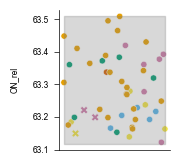

In [176]:
path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Amplifier_pop/Original_hyperparams_vary_dose/Amplifier_pop_vary_dose_original_hp_seed_0/"
CI_fname = "2024-08-23_results_analysis_full_CI/selected_results_ON_rel_full_CI.pkl"
unique_objs_fname = ""
amp_CI = pd.read_pickle(path+CI_fname)

objs0 = []
in_dict0 = {'Z6': {'P': [], 'Z': ['Z6', 'Z2'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z6', 'Z2'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z6', 'Z2'], 'I': []}
}
sorted_in_dict0 = sort_in_dict(in_dict0)

objs1 = []
in_dict1 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z2'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []}
}
sorted_in_dict1 = sort_in_dict(in_dict1)

objs2 = []
in_dict2 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z2', 'Z6'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z6'], 'I': []}
}
sorted_in_dict2 = sort_in_dict(in_dict2)

objs3 = []
in_dict3 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z6'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []}
}
sorted_in_dict3 = sort_in_dict(in_dict3)

objs4 = []
in_dict4 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z6'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z6'], 'I': []}
}
sorted_in_dict4 = sort_in_dict(in_dict4)

objs5 = []
in_dict5 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z2'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z6'], 'I': []}
}
sorted_in_dict5 = sort_in_dict(in_dict5)


in_dict0_general = generalize_in_dict(in_dict0)
# print(in_dict0_general.keys())
in_dict1_general = generalize_in_dict(in_dict1)
# print(in_dict1_general.keys())
in_dict2_general = generalize_in_dict(in_dict2)
# print(in_dict2_general.keys())
in_dict3_general = generalize_in_dict(in_dict3)
# print(in_dict3_general.keys())
in_dict4_general = generalize_in_dict(in_dict4)
# print(in_dict4_general.keys())
in_dict5_general = generalize_in_dict(in_dict5)
# print(in_dict5_general.keys())
dict_list = [sorted_in_dict0, sorted_in_dict1, sorted_in_dict2, sorted_in_dict3, sorted_in_dict4, sorted_in_dict5]
dict_list_general = [in_dict0_general, in_dict1_general, in_dict2_general, in_dict3_general, in_dict4_general, in_dict5_general]
keys_list = [d.keys() for d in dict_list_general]


opt_circuits = {
    "opt_0_topology": [],
    "opt_0_objs": [],
    "opt_0_doses": [],
    "opt_1_topology": [],
    "opt_1_objs": [],
    "opt_1_doses": [],
    "opt_2_topology": [],
    "opt_2_objs": [],
    "opt_2_doses": [],
    "opt_3_topology": [],
    "opt_3_objs": [],
    "opt_3_doses": [],
    "opt_4_topology": [],
    "opt_4_objs": [],
    "opt_4_doses": [],
    "opt_5_topology": [],
    "opt_5_objs": [],
    "opt_5_doses": [],
}
opt_variants = {
    "opt_0_var_topology": [],
    "opt_0_var_objs": [],
    "opt_0_var_doses": [],
    "opt_1_var_topology": [],
    "opt_1_var_objs": [],
    "opt_1_var_doses": [],
    "opt_2_var_topology": [],
    "opt_2_var_objs": [],
    "opt_2_var_doses": [],
    "opt_3_var_topology": [],
    "opt_3_var_objs": [],
    "opt_3_var_doses": [],
    "opt_4_var_topology": [],
    "opt_4_var_objs": [],
    "opt_4_var_doses": [],
    "opt_5_var_topology": [],
    "opt_5_var_objs": [],
    "opt_5_var_doses": [],
}

for index, row in amp_CI.iterrows():
    # print("CI circuit ", index)
    row_in_dict = row["Parts order"]
    sorted_in_dict = sort_in_dict(row_in_dict)
    row_in_dict_general = generalize_in_dict(row_in_dict)
    if sorted_in_dict in dict_list:
        opt_circuit_idx = keys_list.index(row_in_dict_general.keys())
        # print("circuit is opt ", opt_circuit_idx)
        opt_circuits["opt_"+str(opt_circuit_idx)+"_topology"].append(row["Topology"])
        opt_circuits["opt_"+str(opt_circuit_idx)+"_objs"].append(row["ON_rel"])
        opt_circuits["opt_"+str(opt_circuit_idx)+"_doses"].append(row["Topology"].dose)
    elif row_in_dict_general.keys() in keys_list:
        variant_idx = keys_list.index(row_in_dict_general.keys())
        # print("circuit is variant of opt ", keys_list.index(row_in_dict_general.keys()))
        opt_variants["opt_"+str(variant_idx)+"_var_topology"].append(row["Topology"])
        opt_variants["opt_"+str(variant_idx)+"_var_objs"].append(row["ON_rel"])
        opt_variants["opt_"+str(variant_idx)+"_var_doses"].append(row["Topology"].dose)


    # print("*****")
opt_circuits_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in opt_circuits.items()]))
opt_variants_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in opt_variants.items()]))
# opt_circuits_df_nonan = opt_circuits_df.fillna(value="", inplace=False)
opt_objs = opt_circuits_df.drop(list(
    opt_circuits_df.filter(regex="topology")
    ), axis=1)
opt_objs = opt_objs.drop(list(
    opt_circuits_df.filter(regex="doses")
    ), axis=1)
# display(opt_objs)
# display(opt_circuits_df_nonan)
opt_variant_objs = opt_variants_df.drop(list(
    opt_variants_df.filter(regex="topology")
    ), axis=1)
opt_variant_objs = opt_variant_objs.drop(list(
    opt_variants_df.filter(regex="doses")
    ), axis=1)

# opt_circuits_df.to_pickle(path+"topologies_in_CI.pkl")
# opt_circuits_df.to_csv(path+"topologies_in_CI.csv")
# opt_variants_df.to_pickle(path+"topology_variants_in_CI.pkl")
# opt_variants_df.to_csv(path+"topology_variants_in_CI.csv")

opt_objs_T = opt_objs.transpose()
opt_objs_T["opt_topo"] = opt_objs_T.index
# display(opt_objs_T)
opt_variant_objs_T = opt_variant_objs.transpose()
opt_variant_objs_T["opt_topo"] = opt_variant_objs_T.index

opt_objs_plot = pd.melt(frame=opt_objs_T,
                        id_vars="opt_topo",
                        var_name="column_name",
                        value_name="ON_rel")
opt_objs_plot.dropna(inplace=True)

opt_variant_objs_plot = pd.melt(frame=opt_variant_objs_T,
                        id_vars="opt_topo",
                        var_name="column_name",
                        value_name="ON_rel")
opt_variant_objs_plot.dropna(inplace=True)

x_vals = [0]*len(opt_objs_plot)
print(len(x_vals))
np.random.seed(0)
jittered_x = x_vals + np.random.rand(
    len(x_vals))
opt_objs_plot["jittered_x"] = jittered_x
# display(opt_objs_plot)

x_vals_var = [0]*len(opt_variant_objs_plot)
jittered_x_var = x_vals_var + np.random.rand(
    len(x_vals_var))
opt_variant_objs_plot["jittered_x"] = jittered_x_var
# fig, ax = plt.subplots(1, 1, figsize=(3, 3))
# sns.scatterplot(data= opt_variant_objs_plot, x="jittered_x", y="ON_rel", ax=ax, hue="opt_topo", palette=colors)

fig, ax = plt.subplots(1, 1, figsize=(1.9, 1.75))
sns.scatterplot(data= opt_objs_plot, x="jittered_x", y="ON_rel", ax=ax, hue="opt_topo", palette=colors, s=20, legend=False)
sns.scatterplot(data= opt_variant_objs_plot, x="jittered_x", y="ON_rel", ax=ax, hue="opt_topo", palette=[colors[2], colors[5]], marker= "X", s=30, legend=False)
lower_bound = [63.11786016]*len(opt_objs_plot)
upper_bound = [63.50911412131601]*len(opt_objs_plot)
jittered_x.sort()
ax.fill_between(jittered_x, lower_bound, upper_bound, alpha=0.3, color="grey", zorder=3)
ax.set_xticks([])
ax.set_yticks([63.1, 63.2, 63.3, 63.4, 63.5])
ax.set_xlabel("")
# plt.show()
plt.savefig(path+"topologies_in_CI.svg")

### Sub-opt topologies

In [164]:
path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Amplifier_pop/Original_hyperparams_vary_dose/Amplifier_pop_vary_dose_original_hp_seed_0/"
topologies_fname = "unique_circuits.pkl"
objs_fname = "unique_objectives.pkl"

with open(path+topologies_fname, "rb") as fid:
    unique_topos = pickle.load(fid)
unique_topos = unique_topos.flatten()
with open(path+objs_fname, "rb") as fid:
    unique_objs = pickle.load(fid)
unique_objs = abs(unique_objs.flatten())
unique_results = np.column_stack((unique_topos, unique_objs))
# print(unique_results)

unique_results_df = pd.DataFrame(data=unique_results, columns=["Topology", "ON_rel"])
unique_results_subopt = unique_results_df[unique_results_df["ON_rel"] < 63.11786016]
display(unique_results_subopt)

,Topology,ON_rel
0,<define_circuit.Topo object at 0x7fbc34705d50>,35.165417
1,<define_circuit.Topo object at 0x7fbc62c5e590>,25.424231
2,<define_circuit.Topo object at 0x7fbc62c5eda0>,34.532997
3,<define_circuit.Topo object at 0x7fbc62c5eb90>,1.991066
4,<define_circuit.Topo object at 0x7fbc62c5d450>,38.503784
...,...,...
1064,<define_circuit.Topo object at 0x7fbc4714ec80>,50.31328
1065,<define_circuit.Topo object at 0x7fbc4714c6d0>,39.579727
1066,<define_circuit.Topo object at 0x7fbc4714f3d0>,60.725882
1067,<define_circuit.Topo object at 0x7fbc4714f400>,48.623431


/var/folders/ns/9zdlrc210px6q49986n73k1h0000gn/T/ipykernel_46095/949635724.py:176: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  opt_variants_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in opt_variants.items()]))


,opt_topo,column_name,ON_rel,jittered_x
0,opt_0_objs,0,61.056948,0.471765
1,opt_1_objs,0,62.125025,0.872285
2,opt_2_objs,0,59.756150,0.603079
3,opt_2_Z7_objs,0,62.011832,0.896874
4,opt_3_objs,0,62.158321,0.647623
...,...,...,...,...
463,opt_1_objs,66,60.654455,0.379713
470,opt_1_objs,67,61.825713,0.200516
477,opt_1_objs,68,60.088484,0.700547
484,opt_1_objs,69,61.480044,0.890035


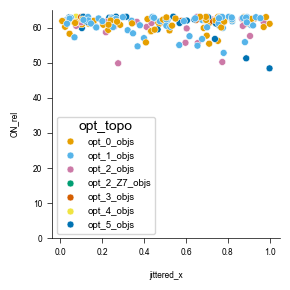

In [136]:
objs0 = []
in_dict0 = {'Z6': {'P': [], 'Z': ['Z6', 'Z2'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z6', 'Z2'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z6', 'Z2'], 'I': []}
}
topo0_edges = [('P1', 'Z2'), ('Z6', 'Z6'), ('Z6', 'Rep'), ('Z6', 'Z2'), ('Z2', 'Z2'), ('Z2', 'Z6'), ('Z2', 'Rep')]
topo0 = nx.DiGraph()
topo0.add_edges_from(topo0_edges)
shortest_path0 = nx.shortest_path(topo0, "P1", "Rep")
# print(shortest_path0)
sorted_in_dict0 = sort_in_dict(in_dict0)

objs1 = []
in_dict1 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z2'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []}
}
topo1_edges = [('P1', 'Z2'), ('Z6', 'Z6'), ('Z6', 'Rep'), ('Z2', 'Z2'), ('Z2', 'Z6'), ('Z2', 'Rep')]
topo1 = nx.DiGraph()
topo1.add_edges_from(topo1_edges)
shortest_path1 = nx.shortest_path(topo1, "P1", "Rep")
# print(shortest_path1)
sorted_in_dict1 = sort_in_dict(in_dict1)

objs2 = []
in_dict2 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z2', 'Z6'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z6'], 'I': []}
}
topo2_edges = [('P1', 'Z2'), ('Z6', 'Z6'), ('Z6', 'Rep'), ('Z6', 'Z2'), ('Z2', 'Z2'), ('Z2', 'Z6')]
topo2 = nx.DiGraph()
topo2.add_edges_from(topo2_edges)
shortest_path2 = nx.shortest_path(topo2, "P1", "Rep")
# print(shortest_path2)
sorted_in_dict2 = sort_in_dict(in_dict2)

objs2_Z7 = []
in_dict2_Z7 = {'Z6': {'P': [], 'Z': ['Z7', 'Z6'], 'I': []},
            'Z7': {'P': ['P1'], 'Z': ['Z7', 'Z6'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z6'], 'I': []}
}
topo2_Z7_edges = [('P1', 'Z7'), ('Z6', 'Z6'), ('Z6', 'Rep'), ('Z6', 'Z7'), ('Z7', 'Z7'), ('Z7', 'Z6')]
topo2_Z7 = nx.DiGraph()
topo2_Z7.add_edges_from(topo2_Z7_edges)
shortest_path2_Z7 = nx.shortest_path(topo2_Z7, "P1", "Rep")
sorted_in_dict2 = sort_in_dict(in_dict2)
sorted_in_dict2_Z7 = sort_in_dict(in_dict2_Z7)

objs3 = []
in_dict3 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z6'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []}
}
topo3_edges = [('P1', 'Z2'), ('Z6', 'Z6'), ('Z6', 'Rep'), ('Z6', 'Z2'), ('Z2', 'Z6'), ('Z2', 'Rep')]
topo3 = nx.DiGraph()
topo3.add_edges_from(topo3_edges)
shortest_path3 = nx.shortest_path(topo3, "P1", "Rep")
sorted_in_dict3 = sort_in_dict(in_dict3)

objs4 = []
in_dict4 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z6'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z6'], 'I': []}
}
topo4_edges = [('P1', 'Z2'), ('Z6', 'Z6'), ('Z6', 'Rep'), ('Z6', 'Z2'), ('Z2', 'Z6')]
topo4 = nx.DiGraph()
topo4.add_edges_from(topo4_edges)
shortest_path4 = nx.shortest_path(topo4, "P1", "Rep")
sorted_in_dict4 = sort_in_dict(in_dict4)

objs5 = []
in_dict5 = {'Z6': {'P': [], 'Z': ['Z2', 'Z6'], 'I': []},
            'Z2': {'P': ['P1'], 'Z': ['Z2'], 'I': []},
            'Rep': {'P': [], 'Z': ['Z6'], 'I': []}
}
topo5_edges = [('P1', 'Z2'), ('Z6', 'Z6'), ('Z6', 'Rep'), ('Z2', 'Z2'), ('Z2', 'Z6')]
topo5 = nx.DiGraph()
topo5.add_edges_from(topo5_edges)
shortest_path5 = nx.shortest_path(topo5, "P1", "Rep")
sorted_in_dict5 = sort_in_dict(in_dict5)


in_dict0_general = generalize_in_dict(in_dict0)
# print(in_dict0_general.keys())
in_dict1_general = generalize_in_dict(in_dict1)
# print(in_dict1_general.keys())
in_dict2_general = generalize_in_dict(in_dict2)
# print(in_dict2_general.keys())
in_dict2_Z7_general = generalize_in_dict(in_dict2_Z7)
# print(in_dict2_general.keys())
in_dict3_general = generalize_in_dict(in_dict3)
# print(in_dict3_general.keys())
in_dict4_general = generalize_in_dict(in_dict4)
# print(in_dict4_general.keys())
in_dict5_general = generalize_in_dict(in_dict5)
# print(in_dict5_general.keys())
dict_list = [sorted_in_dict0, sorted_in_dict1, sorted_in_dict2, sorted_in_dict3, sorted_in_dict4, sorted_in_dict5]
dict_list_general = [in_dict0_general, in_dict1_general, in_dict2_general, in_dict3_general, in_dict4_general, in_dict5_general]
keys_list = [d.keys() for d in dict_list_general]
shortest_path_list = [shortest_path0, shortest_path1, shortest_path2, shortest_path3, shortest_path4, shortest_path5]


opt_circuits = {
    "opt_0_topology": [],
    "opt_0_objs": [],
    "opt_0_doses": [],
    "opt_1_topology": [],
    "opt_1_objs": [],
    "opt_1_doses": [],
    "opt_2_topology": [],
    "opt_2_objs": [],
    "opt_2_doses": [],
    "opt_2_Z7_topology": [],
    "opt_2_Z7_objs": [],
    "opt_2_Z7_doses": [],
    "opt_3_topology": [],
    "opt_3_objs": [],
    "opt_3_doses": [],
    "opt_4_topology": [],
    "opt_4_objs": [],
    "opt_4_doses": [],
    "opt_5_topology": [],
    "opt_5_objs": [],
    "opt_5_doses": [],
}
opt_variants = {
    "opt_0_var_topology": [],
    "opt_0_var_objs": [],
    "opt_0_var_doses": [],
    "opt_1_var_topology": [],
    "opt_1_var_objs": [],
    "opt_1_var_doses": [],
    "opt_2_var_topology": [],
    "opt_2_var_objs": [],
    "opt_2_var_doses": [],
    "opt_3_var_topology": [],
    "opt_3_var_objs": [],
    "opt_3_var_doses": [],
    "opt_4_var_topology": [],
    "opt_4_var_objs": [],
    "opt_4_var_doses": [],
    "opt_5_var_topology": [],
    "opt_5_var_objs": [],
    "opt_5_var_doses": [],
}

for index, row in unique_results_subopt.iterrows():
    # print("CI circuit ", index)
    row_in_dict = row["Topology"].in_dict
    sorted_in_dict = sort_in_dict(row_in_dict)
    row_in_dict_general = generalize_in_dict(row_in_dict)
    if sorted_in_dict in dict_list:
        opt_circuit_idx = keys_list.index(row_in_dict_general.keys())
        # print("circuit is opt ", opt_circuit_idx)
        opt_circuits["opt_"+str(opt_circuit_idx)+"_topology"].append(row["Topology"])
        opt_circuits["opt_"+str(opt_circuit_idx)+"_objs"].append(row["ON_rel"])
        opt_circuits["opt_"+str(opt_circuit_idx)+"_doses"].append(row["Topology"].dose)
    elif sorted_in_dict == sorted_in_dict2_Z7:
        opt_circuits["opt_2_Z7_topology"].append(row["Topology"])
        opt_circuits["opt_2_Z7_objs"].append(row["ON_rel"])
        opt_circuits["opt_2_Z7_doses"].append(row["Topology"].dose)
    elif row_in_dict_general.keys() in keys_list:
        possible_variant = keys_list.index(row_in_dict_general.keys())
        topo_graph = row["Topology"].graph
        shortest_path = nx.shortest_path(topo_graph, "P1", "Rep")
        if len(shortest_path) == len(shortest_path_list[possible_variant]):
        #     print(row["Topology"].in_dict)
        #     print("circuit is variant of opt ", keys_list.index(row_in_dict_general.keys()))
        #     print("***")
            opt_variants["opt_"+str(possible_variant)+"_var_topology"].append(row["Topology"])
            opt_variants["opt_"+str(possible_variant)+"_var_objs"].append(row["ON_rel"])
            opt_variants["opt_"+str(possible_variant)+"_var_doses"].append(row["Topology"].dose)

    # print("*****")
opt_circuits_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in opt_circuits.items()]))
opt_variants_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in opt_variants.items()]))
opt_circuits_df_nonan = opt_circuits_df.fillna(value="", inplace=False)
# opt_variants_df_nonan = opt_variants_df.fillna(value="", inplace=False)
opt_objs = opt_circuits_df.drop(list(
    opt_circuits_df.filter(regex="topology")
    ), axis=1)
opt_objs = opt_objs.drop(list(
    opt_circuits_df.filter(regex="doses")
    ), axis=1)
opt_variant_objs = opt_variants_df.drop(list(
    opt_variants_df.filter(regex="topology")
    ), axis=1)
opt_variant_objs = opt_variant_objs.drop(list(
    opt_variants_df.filter(regex="doses")
    ), axis=1)

# display(opt_objs)
# display(opt_circuits_df_nonan)

# opt_circuits_df.to_pickle(path+"topologies_sub_opt.pkl")
# opt_circuits_df.to_csv(path+"topologies_sub_opt.csv")
# opt_variants_df.to_pickle(path+"topology_variants_sub_opt.pkl")
# opt_variants_df.to_csv(path+"topology_variants_sub_opt.csv")

opt_objs_T = opt_objs.transpose()
opt_objs_T["opt_topo"] = opt_objs_T.index
opt_variant_objs_T = opt_variant_objs.transpose()
opt_variant_objs_T["opt_topo"] = opt_variant_objs_T.index
# display(opt_objs_T)

opt_objs_plot = pd.melt(frame=opt_objs_T,
                        id_vars="opt_topo",
                        var_name="column_name",
                        value_name="ON_rel")
opt_objs_plot.dropna(inplace=True)
# print(len(opt_objs_plot))
opt_variant_objs_plot = pd.melt(frame=opt_variant_objs_T,
                        id_vars="opt_topo",
                        var_name="column_name",
                        value_name="ON_rel")
opt_variant_objs_plot.dropna(inplace=True)
# print(len(opt_variant_objs_plot))
x_vals = [0]*len(opt_objs_plot)
jittered_x = x_vals + np.random.rand(
    len(x_vals))
opt_objs_plot["jittered_x"] = jittered_x
display(opt_objs_plot)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sns.scatterplot(data= opt_objs_plot, x="jittered_x", y="ON_rel", ax=ax, hue="opt_topo", palette=colors)
plt.ylim([0, 65])
plt.show()

# x_vals_var = [0]*len(opt_variant_objs_plot)
# jittered_x_var = x_vals_var + np.random.rand(
#     len(x_vals_var))
# opt_variant_objs_plot["jittered_x"] = jittered_x_var
# fig, ax = plt.subplots(1, 1, figsize=(3, 3))
# sns.scatterplot(data= opt_variant_objs_plot, x="jittered_x", y="ON_rel", ax=ax, hue="opt_topo", palette=colors)
# plt.ylim([0, 65])
# plt.show()
# opt_variant_objs_low_plot = opt_variant_objs_plot[opt_variant_objs_plot["ON_rel"] < 60]
# print(len(opt_variant_objs_low_plot))


# opt_objs_low_plot = opt_objs_plot[opt_objs_plot["ON_rel"] < 60]
# # display(opt_objs_low_plot)
# print(len(opt_objs_low_plot))

# x_vals = [0]*len(opt_objs_low_plot)
# jittered_x = x_vals + np.random.rand(
#     len(x_vals))
# opt_objs_low_plot["jittered_x"] = jittered_x
# # # display(opt_objs_plot)
# fig, ax = plt.subplots(1, 1, figsize=(3, 3))
# sns.scatterplot(data= opt_objs_low_plot, x="jittered_x", y="ON_rel", ax=ax, hue="opt_topo", palette=colors)
# plt.ylim([0, 65])
# plt.show()

### Find objectives that fall within pareto CI

In [27]:
# sc_pop_path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Signal_conditioner_pop/synTF-R-DsR/Original_hyperparams/SC_original_hp_seed_0/"
sc_pop_path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Signal_conditioner_pop/synTF-R-DsR/Single_cell_model_opt_hyperparams/run2_ngen80/Single_cell_opt_hp_seed_0/"

obj_fname = "unique_objectives_df.pkl"
pareto_fname = "final_objectives_df.pkl"

circuit_fname = "unique_circuits.pkl"
# CI_path = "2024-09-06_Z_matrix_sampling/Z_matrix_sampling_for_CI.pkl"

pareto_front_objectives = pd.read_pickle(
    sc_pop_path+pareto_fname
)
selected_objectives = (
    pareto_front_objectives.drop_duplicates()
)
display(selected_objectives)
unique_obj_df = pd.read_pickle(sc_pop_path+obj_fname).abs()
with open(sc_pop_path+circuit_fname, "rb") as fid:
    sc_pop20_circuits = pickle.load(fid)
sc_pop20_circuits = sc_pop20_circuits.flatten()

# CI_sampling = pd.read_pickle(sc_pop_path+CI_path)
# display(CI_sampling)
# print(max(CI_sampling["ON_rel_std_error"]), max(CI_sampling["FI_rel_std_error"]))


,ON_rel,FI_rel,type
0,-1.204686,-1.059821,Inhibitors
2,-63.372482,-0.452434,Activators
4,-3.802797,-1.006850,Inhibitors
5,-5.165626,-0.946314,Activators
6,-51.331661,-0.467397,Activators
...,...,...,...
187,-27.675415,-0.696290,Activators
189,-21.636408,-0.774110,Activators
190,-41.541379,-0.576858,Activators
195,-41.810924,-0.575330,Activators


In [ ]:
obj_labels = ["ON_rel", "FI_rel"]
CI_metric_maxes = [0.7285110622796277, 0.026919138877793805]
obj1_CI = CI_metric_maxes[0]
obj2_CI = CI_metric_maxes[1]

upper_obj1 = np.abs(np.array(selected_objectives[obj_labels[0]]))
sorted_upper_idx = np.argsort(upper_obj1)
sorted_upper_obj1 = upper_obj1[sorted_upper_idx]

lower_obj1 = np.array([i-obj1_CI for i in upper_obj1])
sorted_lower_idx = np.argsort(lower_obj1)
sorted_lower_obj1 = lower_obj1[sorted_lower_idx]

upper_obj2 = np.abs(np.array(selected_objectives[obj_labels[1]]))
sorted_upper_obj2 = upper_obj2[sorted_upper_idx]

lower_obj2 = np.array([i-obj2_CI for i in upper_obj2])
sorted_lower_obj2 = lower_obj2[sorted_lower_idx]

xfill = np.sort(np.concatenate([upper_obj1, lower_obj1]))

y1fill = np.interp(xfill, sorted_upper_obj1, sorted_upper_obj2)
y2fill = np.interp(xfill, sorted_lower_obj1, sorted_lower_obj2)

unique_obj_df_CI = unique_obj_df[
    (unique_obj_df["FI_rel"] >= np.interp(unique_obj_df["ON_rel"], xfill, y2fill)) &
    (unique_obj_df["FI_rel"] <= np.interp(unique_obj_df["ON_rel"], xfill, y1fill))
]
# display(unique_obj_df_CI)
CI_idx = unique_obj_df_CI.index.tolist()
unique_circuits_CI = sc_pop20_circuits[CI_idx]
unique_results_CI = unique_obj_df_CI.copy()
unique_results_CI["Topology"] = unique_circuits_CI
unique_results_CI["Edge_list"] = 0
unique_results_CI["Edge_list"] = unique_results_CI["Edge_list"].astype(object)
unique_results_CI["Edge_list"] = [topology.edge_list for topology in unique_circuits_CI]
high_FI_df = unique_results_CI.copy()
high_FI_df = high_FI_df[high_FI_df["FI_rel"] > 1]
display(high_FI_df)
for index, row in high_FI_df.iterrows():
    # print(row["Edge_list"])
    row["Topology"].plot_graph()


# plt.plot(unique_obj_df["ON_rel"], unique_obj_df["FI_rel"], linestyle="none", marker="o", markersize="2", color="grey")
# plt.plot(unique_obj_df_CI["ON_rel"], unique_obj_df_CI["FI_rel"], linestyle="none", marker="o", markersize="2")
# plt.plot(xfill, y1fill, linewidth="2")
# plt.plot(xfill, y2fill, linewidth="2")

In [15]:
path = "/Users/kdreyer/Library/CloudStorage/OneDrive-NorthwesternUniversity/KatieD_LL/GCAD_Collab/Selected_GA_results_paper/Signal_conditioner_single_cell/synTF-R-DsR/Optimized_hyperparams_fixed_pop_opt_stdev_ngen50/run2_ngen80/SC_opt_hp_ngen50_run2_seed_7/"
fname = "all_objectives.pkl"
fname_circuits = "all_circuits.pkl"
all_objs = pd.read_pickle(path+fname)
all_circuits = pd.read_pickle(path+fname_circuits)
unique_objs, unique_idx = np.unique(all_objs, axis=0, return_index=True)
unique_objs = abs(unique_objs)
# print(len(unique_objs))
unique_circuits = all_circuits[unique_idx]
# with open(path+"unique_circuits.pkl", "wb") as fid:
#     pickle.dump(unique_circuits, fid)
# unique_obj_df = pd.DataFrame(unique_objs, columns=["ON_rel", "FI_rel"])
# unique_obj_df.to_pickle(path+"unique_objectives.pkl")
# fig, ax = plt.subplots(1, 1, figsize=(2.25, 2.25))
sns.scatterplot(data=unique_obj_df, x="ON_rel", y="FI_rel", color="k", ax=ax, s=8, linewidth=0.0)
# plt.savefig(path+"unique_obj_scatter.svg")

<AxesSubplot:xlabel='ON_rel', ylabel='FI_rel'>

In [25]:
unique_obj_high = unique_obj_df[unique_obj_df["FI_rel"] > 1]
idx_high = unique_obj_high.index.tolist()
unique_circuits_high = unique_circuits[idx_high]
# display(unique_obj_high)
edge_list_high = []
doses_high = []
for i, circuit in enumerate(unique_circuits_high):
    edge_list_high.append(circuit[0].edge_list)
    doses_high.append(circuit[0].dose)
    # circuit[0].plot_graph()
unique_results_high = unique_obj_high.copy()
unique_results_high["Edge_list"] = 0
unique_results_high["Edge_list"] = unique_results_high["Edge_list"].astype(object)
unique_results_high["Edge_list"] = edge_list_high
unique_results_high["Doses"] = 0
unique_results_high["Doses"] = unique_results_high["Doses"].astype(object)
unique_results_high["Doses"] = doses_high
# display(unique_results_high)
unique_results_high.to_csv(path+"FI_rel_gt1.csv")

# fig, ax = plt.subplots(1, 1, figsize=(2.25, 2.25))
# sns.scatterplot(data=unique_obj_high, x="ON_rel", y="FI_rel", color="k", ax=ax, s=8, linewidth=0.0)
# plt.show()

In [ ]:
CI_stderrs = [0.7285110622796277, 0.026919138877793805]